In [ ]:
# might need to run this next line and restart the session for for it to work on Colab
# !pip install python-crfsuite

import pandas as pd
import re
import nltk

from nltk.tag.hmm import HiddenMarkovModelTrainer
from nltk.tag.tnt import TnT
from nltk.tag.perceptron import PerceptronTagger
from nltk.tag import CRFTagger

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from IPython.display import display_html, HTML
from tqdm.notebook import tqdm
import pprint, time
import seaborn as sns


nltk.download('averaged_perceptron_tagger')
nltk.download('treebank')

# Lab 4

For the fourth practical of the subject, the goal is to get in touch with some PoS models. The statement is as follows:

1. Consider Treebank corpus.
  *   Train HMM, TnT, perceptron and CRF models using the first 500, 1000, 1500, 2000, 2500 and 3000 sentences.
  *   Evaluate the resulting 24 models using sentences from 3001.

2. Provide a figure with four learning curves, each per model type (X=training set size; Y=accuracy).
  *   Which model would you select? Justify the answer.

## Training and testing the models

For each training set size (500, 1000, 1500, 2000, 2500 and 3000 sentences from `treebank`), we import the train data and train and evaluate each model by: 

1.   Selecting the trainer (HMM, TnT, perceptron or CRF)
2.   Checking the starting time with the `time.perf_counter()` function
3.   Performing the actual training with the train data 
4.   Calculating the difference between the time when the training finishes and the starting time saved previously
5.   Calculating the accuracy of the model with the testing set (sentences from 3001)


We create two different functions to help us on our goal:
  - `model_train`: which given a model: HMM, TnT, Perceptron, CRF, it will train it on a given train dataset, and then evaluate its accuracy on a given test dataset. We also measure the time elapsed on training as well as to evaluate the test data.
  - `trainer`: which given a dataset, a list with different sizes to partition it, and where to cut for the test data, will run `model_train` on each of the defined models (HMM, TnT, Perceptron, CRF), on the different partition sizes of the dataset. This function will aggregate the accuracies of each model with its training size and the elapsed times.

In [ ]:
models = {
    'HMM': HiddenMarkovModelTrainer(),
    'TnT': TnT(),
    'PER': PerceptronTagger(load=False),
    'CRF': CRFTagger()
}

def model_train(model, train, test):
    # set the model
    MODEL = models[model]
    
    # train the models and record time training 
    start = time.perf_counter()
    if model == 'HMM':
      MODEL = MODEL.train_supervised(train)  # cant they have it be the same
    elif model == 'CRF':
      MODEL.train(train, 'crf_tagger_model') # why do they have three different ways to do it
    else:
      MODEL.train(train)                     # please just make this the default
    training_time = time.perf_counter()-start

    # get accuracy on test

    start = time.perf_counter()
    accuracy = round(MODEL.accuracy(test), 3)
    evaluation_time = time.perf_counter()-start

    return accuracy, training_time, evaluation_time

In [ ]:
def trainer(data, train_sizes, test_size):
  # subset the test_size
  test = data[test_size:]

  columns = ['Model']
  results = [models.keys()]
  times_train = [models.keys()]
  times_eval = [models.keys()]

  total = len(models)*len(train_sizes)

  # create the progress bar
  with tqdm(range(total)) as bar:
    # for each size in the trianing size list
    for size in train_sizes:
      # subset the train size
      train = data[:size]
      
      # lists to save the results
      columns.append(str(size))
      res = []
      tim = []
      tim2 = []

      # for each of the models defined in the dictionary
      for m in models.keys():
        bar.set_description(f'Training {m} with dataset of size {size}') # update bar
        acc, t_train, t_eval = model_train(m, train, test)  # train the model and get accuracy and training time
        res.append(acc) # save the results
        tim.append(t_train)
        tim2.append(t_eval)
        bar.update() # update bar

      results.append(res)
      times_train.append(tim)
      times_eval.append(tim2)

  # save results in dataframes
  df_results = pd.DataFrame(data = results, index = columns).transpose()
  df_times_train = pd.DataFrame(times_train, index = columns).transpose()
  df_times_eval = pd.DataFrame(times_eval, index = columns).transpose()
  df_time = df_times_train + df_times_eval
  df_time.Model = df_results.Model

  return df_results, df_time, df_times_train, df_times_eval

In [ ]:
# train the models with the subsets of data defined for test and 3001-end for test
df, df_time, df_train, df_eval = trainer(nltk.corpus.treebank.tagged_sents(), [500, 1000, 1500, 2000, 2500, 3000], 3000) # [3000:] will get the 3001st observation 

  0%|          | 0/24 [00:00<?, ?it/s]

## Accuracies

Once all the models have been tested, we create a dataframe with the accuracies for each model with each training set size (500, 1000, 1500, 2000, 2500, 3000). We display the dataframe sorting the values to see which model has better accuracy when training it with 3000 sentences. 

The most accurate model (not only when training it with 3000 sentences, but for every training set size) is the **perceptron** model, followed by CRF.

In [ ]:
HTML(df.sort_values(by = ['3000'], ascending=False).to_html(index=False))

Model,500,1000,1500,2000,2500,3000
PER,0.912,0.932,0.941,0.948,0.952,0.955
CRF,0.91,0.925,0.933,0.939,0.943,0.947
TnT,0.747,0.796,0.827,0.848,0.862,0.875
HMM,0.173,0.221,0.262,0.304,0.335,0.368


## Learning curves

Now, for each model, we plot its **learning curve**, where the `x` axis corresponds to the size of the training set and the `y` axis corresponds to the accuracy achieved by the model with that amount of training samples. 

We then create a dataframe in order to display, for each model, the difference between the accuracy of the model training it with 3000 sentences and training it with only 500 sentences. 

From the learning curves and the dataframe, we can tell the model that improves the most when increasing the size of the training set is the **HMM** model, followed by TnT. Perceptron and CRF seem to work very well already with only 500 words.

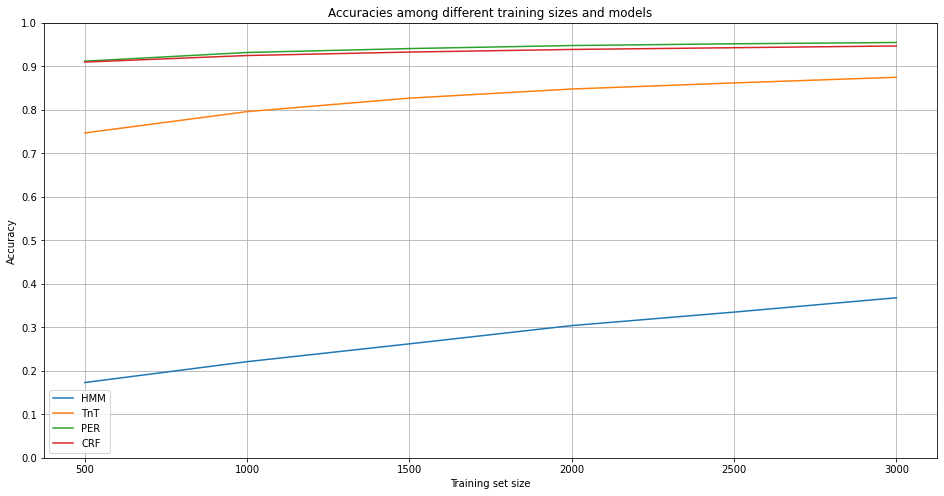

In [ ]:
df_tran = df.T
df_tran.rename(columns = df_tran.iloc[0], inplace = True)
df_tran.drop(df_tran.index[0], inplace = True)

plt.rcParams['figure.figsize'] = [16, 8]
ax = df_tran.plot(grid = True)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Accuracies among different training sizes and models')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.ylim(0, 1)  
plt.show()

In [ ]:
df['Accuracy improvement'] = df['3000'] - df['500']
HTML(df[['Model', 'Accuracy improvement']].to_html(index=False))

Model,Accuracy improvement
HMM,0.195
TnT,0.128
PER,0.043
CRF,0.037


## Performance

As we've been calculating the time that it takes to train each model with each training set size, we compare their performance by showing a plot where the `x` axis is the size of the training set and the `y` axis the elapsed time it took to train the model, and to evaluate it in the test set. The legend indicates us the color which corresponds to each model, and the shape of the line representing if it represents the training time, time it takes to predict and evaluate the test set, or total time (train + evaluation).  

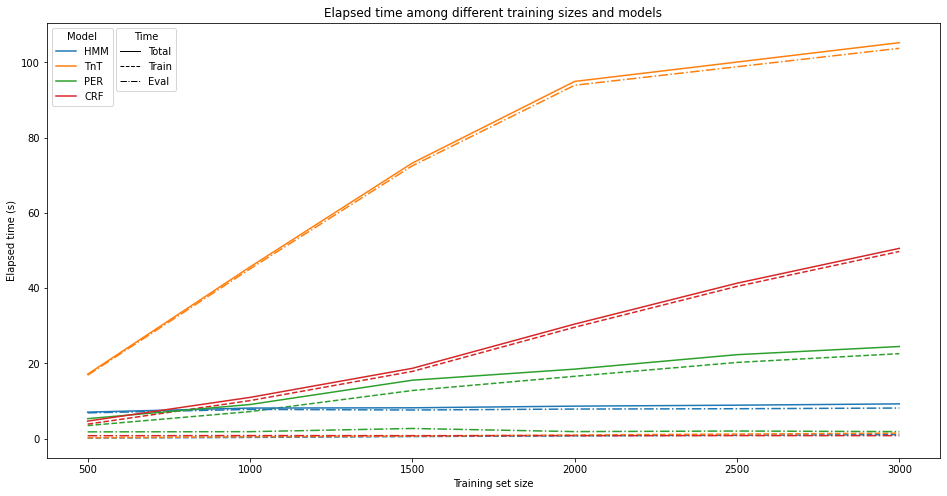

In [ ]:
from matplotlib.lines import Line2D

df_ti = pd.melt(df_time, id_vars='Model')
df_tr = pd.melt(df_train, id_vars='Model') 
df_ev = pd.melt(df_eval, id_vars='Model') 
df_ti['Time'] = 'Total'
df_tr['Time'] = 'Train'
df_ev['Time'] = 'Evaluation'

ax = sns.lineplot(data = df_tr, x = 'variable', y = 'value', hue = 'Model', legend = False, linestyle = '--')
ax = sns.lineplot(data = df_ev, x = 'variable', y = 'value', hue = 'Model', legend = False, linestyle = '-.' )

custom_lines = [Line2D([0], [0], color = 'black', lw=1, ls = '-'),
                Line2D([0], [0], color = 'black', lw=1, ls = '--'),
                Line2D([0], [0], color = 'black', lw=1, ls = '-.')]


l = plt.legend(custom_lines, ['Total', 'Train', 'Eval'], bbox_to_anchor = (0.15,1.0), title="Time")
_ = plt.xlabel('Training set size')
_ = plt.ylabel('Elapsed time (s)')
_ = plt.title('Elapsed time among different training sizes and models')
ax = sns.lineplot(data = df_ti, x = 'variable', y = 'value', hue = 'Model')
_ = plt.gca().add_artist(l)

In [ ]:
print('Total elapsed time')
HTML(df_time.sort_values(by = ['3000'], ascending=False).to_html(index=False))

Total elapsed time


Model,500,1000,1500,2000,2500,3000
TnT,17.155647,45.633261,73.240405,94.921082,100.065704,105.212503
CRF,4.694642,10.990306,18.710772,30.462228,41.318224,50.579473
PER,5.342425,9.097515,15.55762,18.499245,22.336805,24.509696
HMM,7.081719,8.158622,8.229333,8.671058,8.922932,9.269512


In [ ]:
print('Elapsed time evaluating test')
HTML(df_eval.sort_values(by = ['3000'], ascending=True).to_html(index=False))

Elapsed time evaluating test


Model,500,1000,1500,2000,2500,3000
CRF,0.807307,0.848429,0.822247,0.838273,0.842597,0.830865
PER,1.835338,1.884834,2.737703,1.902126,2.058346,1.900734
HMM,6.884255,7.801319,7.64052,7.895353,7.982885,8.163211
TnT,16.89242,45.107121,72.506161,93.905727,98.815792,103.716178


In [ ]:
print('Average execution time of the test set, sorted by fastest')
df_aux = df_eval.set_index('Model')
test_size = len(nltk.corpus.treebank.tagged_sents()[3000:])
(df_aux/test_size).sort_values(by = ['3000'])

Average execution time of the test set, sorted by fastest


,500,1000,1500,2000,2500,3000
Model,,,,,,
CRF,0.000883,0.000928,0.0009,0.000917,0.000922,0.000909
PER,0.002008,0.002062,0.002995,0.002081,0.002252,0.00208
HMM,0.007532,0.008535,0.008359,0.008638,0.008734,0.008931
TnT,0.018482,0.049351,0.079328,0.102741,0.108114,0.113475


In [ ]:
print('Times slower compared to CRF')
df_aux.div(df_aux.loc['CRF'], axis = 'columns').sort_values(by = ['3000'])

Times slower compared to CRF


,500,1000,1500,2000,2500,3000
Model,,,,,,
CRF,1.0,1.0,1.0,1.0,1.0,1.0
PER,2.273407,2.221559,3.32954,2.269099,2.442861,2.287658
HMM,8.527428,9.195022,9.292247,9.418589,9.474148,9.824959
TnT,20.924398,53.16549,88.18054,112.022782,117.275329,124.829222


# Conclusions

Checking the learning curve, we see that both the perceptron and the CRF have learned very quickly. With only a sample set of 500 they already achieve a high performance. However, they seem to be a bit stuck there, since increasing the training size to 3000 does not really make them improve much. 

HMM and TnT seem to be the most affected by increasing the training size, however this is not saying much about the HMM model since it works abysmally bad. Reaching a maximum accuracy of 0.368 with a training set of 3000 words, compared to 0.173 using 500. While the improvement of using TnT seems to also learn more than both the CRF and perceptron, the overall accuracy is low compared to the other two. Hence, we would prefer either CRF or the perceptron, since they both give the best accuracies. 

Since both CRF and the perceptron give similar accuracies, we decided to compare the elapsed time of training and its execution time to see which would be better suited for real time applications. Observing the last few tables and the plot, we can see that while the CRF takes a lot of time to train, it actually goes the fastest to execute each prediction. Hence, if we were in a very time critical application, seeing how they both give pretty much the same accuracy, we might decide to go with the CRF, since the perceptron goes more than 2 times slower on average.

Out of all the models, HMM train's the fastest, followed very closely by TnT. Regarding execution time, HMM is 9 times slower on average than CRF. Finally, TnT is the slowest model compared to all of them regarding execution time. Which we find hilarious since looking at the [paper `nltk` cites](https://aclanthology.org/A00-1031.pdf), literally the first line says: "(TnT) is an efficient statistical part-of-speech tagger". We hope they meant efficient in the sense of accuracy.


**Which model would you select? Justify the answer.**

After comparing the accuracies and the elapsed time of each of the models with each of the training set sizes (500, 1000, 1500, 2000, 2500 and 3000 sentences) and having displayed some useful plots and dataframes for comparison, we have come to the following conclusion:

*   The **best model** overall is the **perceptron**, as it's the one that gives us the highest accuracy value independent of the training size, and, although its training time is not the best, it's still quite reasonable when compared, for instance, with CFR (which takes time to train). Although, training time should not be the metric we focus, since POS taggers are trained once and used a multitude of times. Hence, we should always train with the largest dataset available, irrespective of the time saved by training with smaller datasets.

  If the application were time critical, it might be of interest sacrificing the 0.08 increase in accuracy, for the increase in time speed won with the CRF. However, as seen in the previous lab, a wrong POS can cascade into other problems - wrong POS → wrong lemmatizing → wrong detection of paraphrases - resulting in worse performances. Hence, for our practical, since the only time critical part is sending it before the 15th of October, we would rather use the perceptron.


<!-- 
*   The **HMM** model is the one that has the **best performance** of all when training it with up to 3000 sentences, as its learning curve is quite more evident than the rest's and it takes very little time to compute the training. However, we should see if the learning curve and the performance in time is as good when testing the training with a much bigger training set size. 
-->


